In [1]:
%pip install -q -r requirements.txt
import sys
print(f"Python {sys.version}")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from myo_utils import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = FIGURE_SIZE

Note: you may need to restart the kernel to use updated packages.
Python 3.11.14 | packaged by conda-forge | (main, Jan 26 2026, 23:39:55) [MSC v.1944 64 bit (AMD64)]


In [2]:
train, train_labels, valid, valid_labels, test, test_labels = load_data_curated()

../myo-readings-dataset/_readings_right_hand/12345-1\0.txt
../myo-readings-dataset/_readings_right_hand/12345-1\1.txt
../myo-readings-dataset/_readings_right_hand/12345-1\2.txt
../myo-readings-dataset/_readings_right_hand/12345-1\3.txt
../myo-readings-dataset/_readings_right_hand/12345-1\4.txt
../myo-readings-dataset/_readings_right_hand/12345-1\5.txt
../myo-readings-dataset/_readings_right_hand/12345-1\6.txt
../myo-readings-dataset/_readings_right_hand/12345-1\7.txt
../myo-readings-dataset/_readings_right_hand/21547-1\0.txt
../myo-readings-dataset/_readings_right_hand/21547-1\1.txt
../myo-readings-dataset/_readings_right_hand/21547-1\2.txt
../myo-readings-dataset/_readings_right_hand/21547-1\3.txt
../myo-readings-dataset/_readings_right_hand/21547-1\4.txt
../myo-readings-dataset/_readings_right_hand/21547-1\5.txt
../myo-readings-dataset/_readings_right_hand/21547-1\6.txt
../myo-readings-dataset/_readings_right_hand/21547-1\7.txt
../myo-readings-dataset/_readings_right_hand/45612-1\0.t

In [3]:
# train, train_labels, valid, valid_labels, test, test_labels = load_data_all()

In [4]:
# Regenerate curated.txt: trains a small model per participant, keeps those above threshold.
# Uses myo_utils defaults: READINGS_DIR, CURATED_FILE, CURATION_ACCURACY_THRESHOLD.
# Optional: generate_curated(readings_dir=..., output_file=..., accuracy_threshold=...)
# generate_curated()

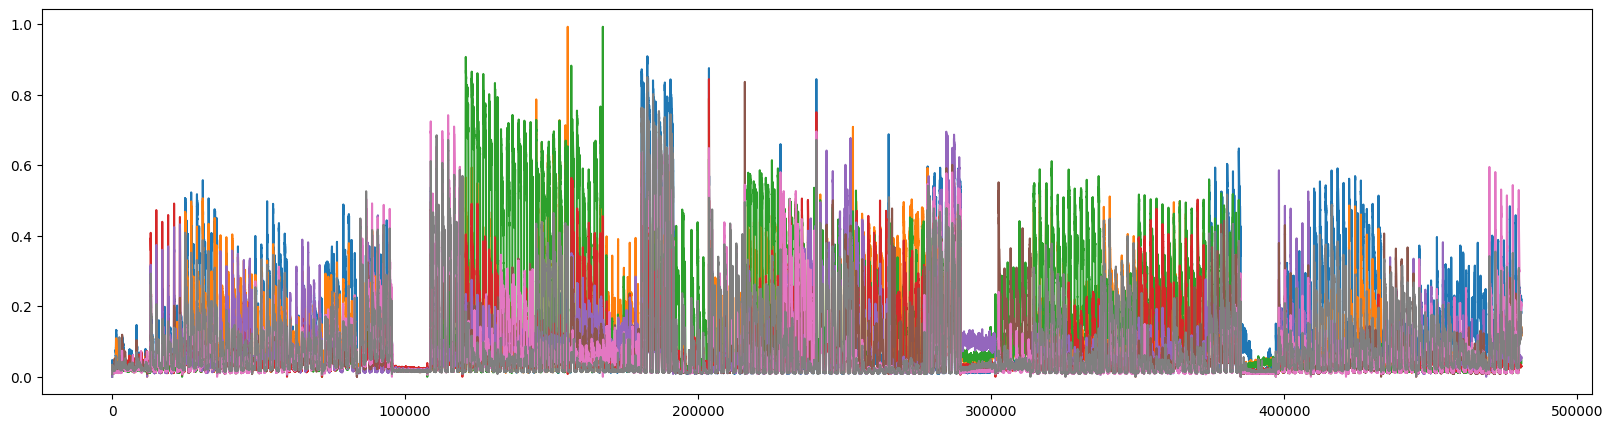

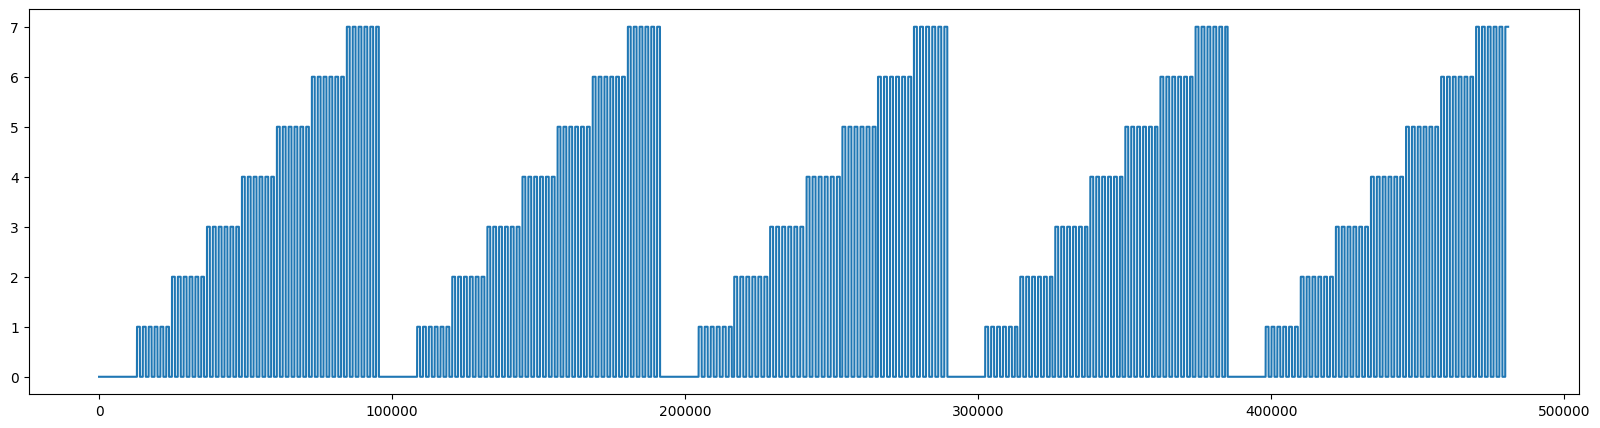

In [5]:
plt.figure()
plt.plot(train)
plt.figure()
plt.plot(train_labels)

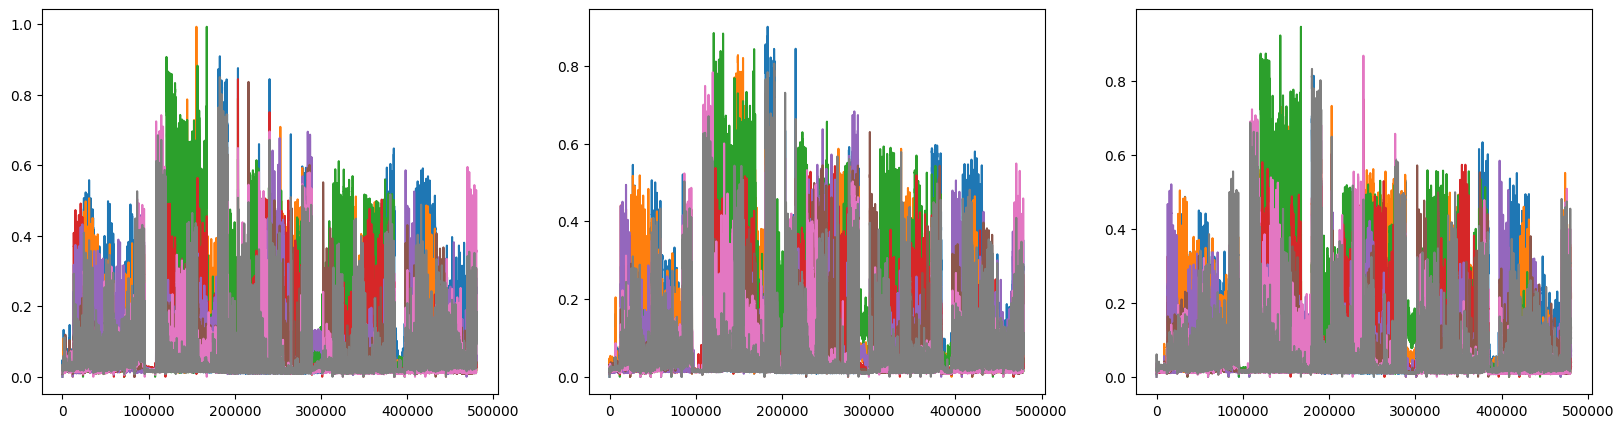

In [6]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train)
ax[1].plot(valid)
ax[2].plot(test)

In [7]:
model = keras.Sequential([
    keras.layers.Input(shape=(NUM_EMG_CHANNELS,)),
    keras.layers.Dense(LAYER_SIZES[0], activation = "relu"),
    keras.layers.Dense(LAYER_SIZES[1], activation = "relu"),
    keras.layers.Dense(LAYER_SIZES[2], activation = "relu"),
    keras.layers.Dense(NUM_GESTURES, activation = "sigmoid")
])

opt = keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

## Training

Fit with early stopping on validation loss and save weights each epoch; after training, the best weights (from the checkpoint) are loaded.

In [8]:
model_checkpoint = ModelCheckpoint(WEIGHTS_FILE, save_weights_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = PATIENCE)
history = model.fit(train, train_labels, 
                    validation_data = (valid, valid_labels), 
                    epochs = EPOCHS, 
                    callbacks = [early_stopping, model_checkpoint])
model.load_weights(WEIGHTS_FILE)

Epoch 1/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8987 - loss: 0.3668 - val_accuracy: 0.8330 - val_loss: 0.6402
Epoch 2/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.9306 - loss: 0.2484 - val_accuracy: 0.8118 - val_loss: 0.8233
Epoch 3/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.9386 - loss: 0.2120 - val_accuracy: 0.8118 - val_loss: 0.8255
Epoch 4/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.9438 - loss: 0.1889 - val_accuracy: 0.8218 - val_loss: 0.8918
Epoch 5/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9480 - loss: 0.1712 - val_accuracy: 0.8134 - val_loss: 1.0237
Epoch 6/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.9512 - loss: 0.1579 - val_accuracy: 0.8056 - val_loss: 1.0990


$\mathcal{L}_{\text{train}}$ and $\mathcal{L}_{\text{val}}$ over epochs. A growing gap suggests overfitting.

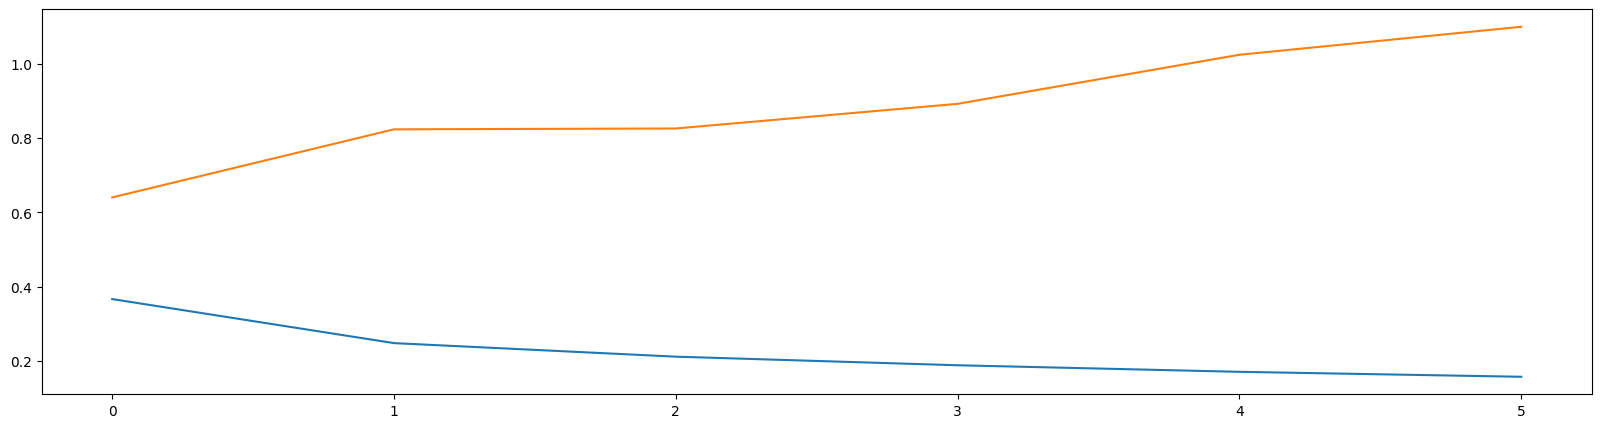

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Training vs validation accuracy over epochs.

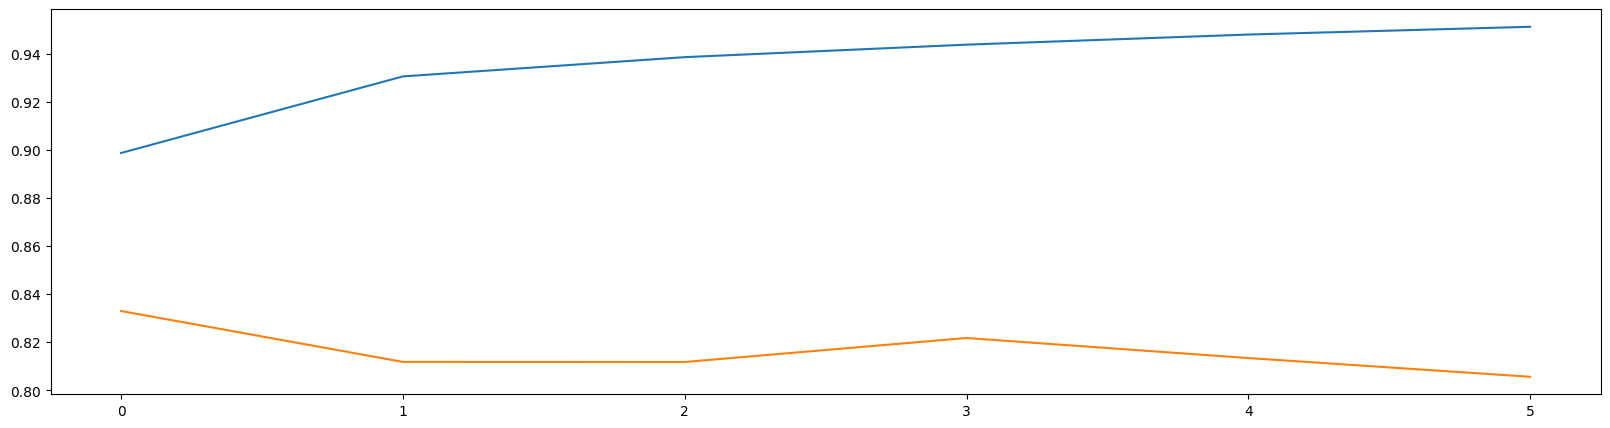

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

Test set: overall $\mathcal{L}$ and accuracy.

In [11]:
model.evaluate(test, test_labels)

15012/15012 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.7492 - loss: 1.7786


[1.7786178588867188, 0.7491667866706848]

In [12]:
predictions = model.predict(test)

15012/15012 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


Confusion matrix: rows = ACTUAL, columns = PREDICTED. Diagonal = correct predictions; off-diagonal = errors. With `normalize="pred"`, each column sums to 1 (precision per predicted class).

In [13]:
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(test_labels, predicted_labels, normalize="pred")
conf

array([[7.50741483e-01, 8.42969552e-02, 7.14155584e-02, 8.00159236e-02,
        6.59965035e-02, 9.60271318e-02, 1.51448733e-01, 1.74834976e-01],
       [4.57462897e-02, 7.43893260e-01, 2.91492075e-03, 7.51194268e-02,
        3.49650350e-03, 4.50581395e-03, 0.00000000e+00, 6.29351659e-02],
       [2.63592882e-02, 0.00000000e+00, 8.59036254e-01, 3.74601911e-02,
        9.36563437e-03, 1.90406977e-02, 3.80626537e-02, 0.00000000e+00],
       [3.06323416e-02, 5.47382826e-04, 3.64365094e-04, 7.44625796e-01,
        1.68581419e-03, 2.28682171e-02, 9.46220464e-03, 1.21620400e-02],
       [3.42547654e-02, 4.78275744e-02, 1.61231554e-02, 0.00000000e+00,
        8.23676324e-01, 5.76550388e-03, 2.04212552e-01, 6.46532236e-03],
       [3.22589154e-02, 9.37393089e-03, 6.55857169e-03, 6.24601911e-02,
        4.76398601e-02, 7.54312016e-01, 4.53330482e-02, 0.00000000e+00],
       [4.54825209e-02, 9.07971262e-02, 7.28730188e-04, 3.18471338e-04,
        1.82317682e-02, 9.66085271e-02, 5.47150647e-01, 3.

In [14]:
legend = GESTURE_LABELS

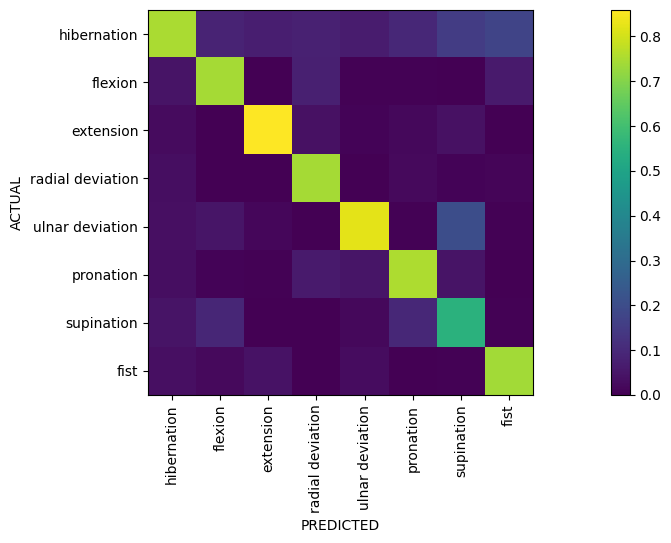

In [15]:
plt.imshow(conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(legend)), legend)
plt.xticks(np.arange(len(legend)), legend, rotation='vertical')
plt.colorbar()

Per-class: $\text{Precision}_k = \frac{TP_k}{TP_k+FP_k}$, $\text{Recall}_k = \frac{TP_k}{TP_k+FN_k}$, $\text{F1}_k = 2\frac{P_k R_k}{P_k+R_k}$; support and macro/weighted averages at the bottom.

In [16]:
print(classification_report(test_labels, predicted_labels, target_names=GESTURE_LABELS))

                  precision    recall  f1-score   support

     hibernation       0.75      0.95      0.84    270708
         flexion       0.74      0.36      0.49     29973
       extension       0.86      0.63      0.73     30051
radial deviation       0.74      0.62      0.68     30118
 ulnar deviation       0.82      0.44      0.57     30015
       pronation       0.75      0.52      0.61     30037
      supination       0.55      0.35      0.42     29470
            fist       0.74      0.55      0.63     30007

        accuracy                           0.75    480379
       macro avg       0.75      0.55      0.62    480379
    weighted avg       0.75      0.75      0.73    480379



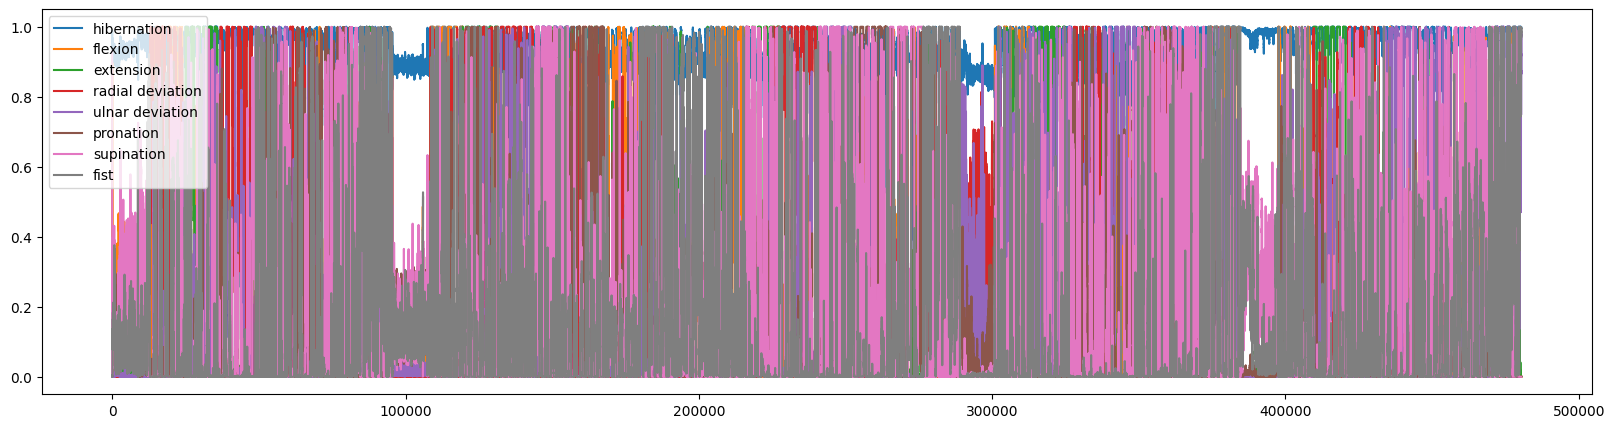

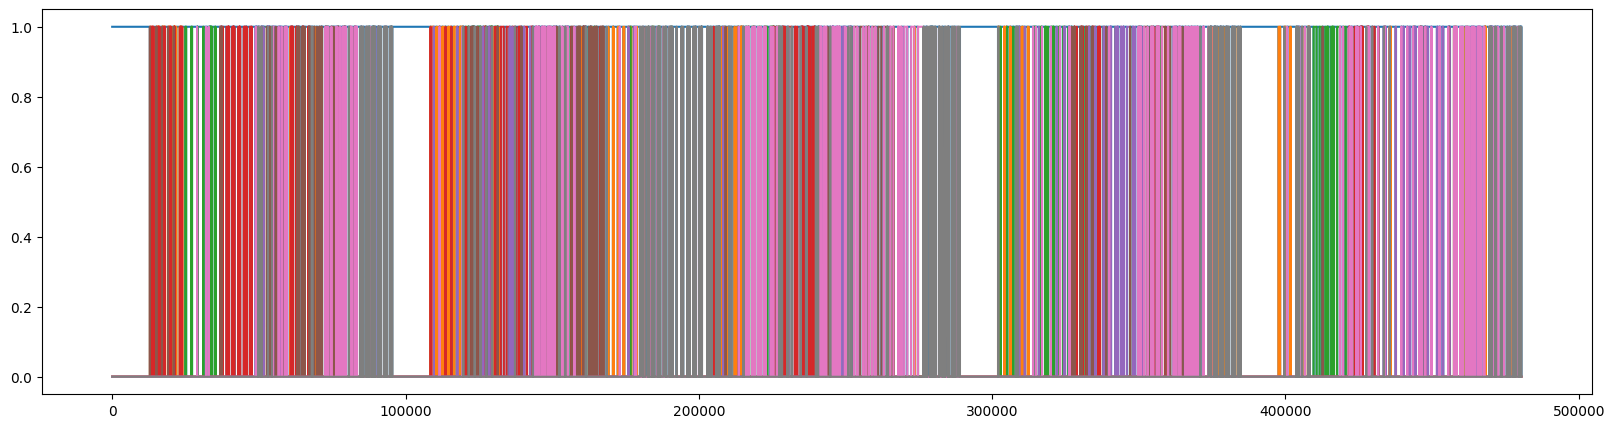

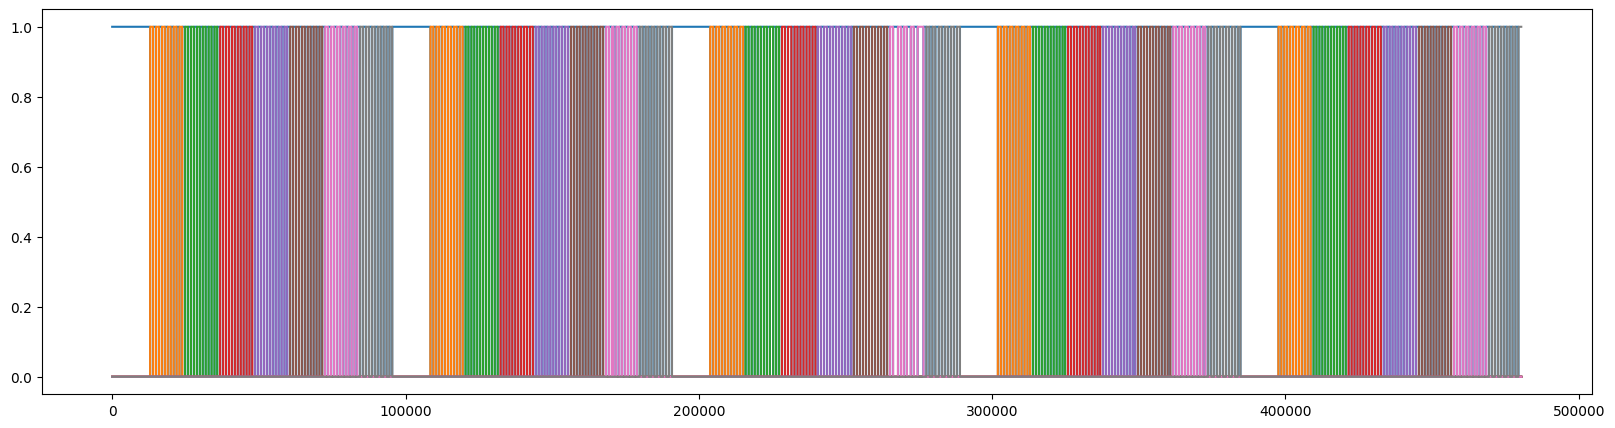

In [17]:
plt.figure()
plt.plot(predictions)
plt.legend(legend, loc = "upper left")

predicted_labels_onehot = keras.utils.to_categorical(predicted_labels, num_classes = NUM_GESTURES)
test_labels_onehot = keras.utils.to_categorical(test_labels, num_classes = NUM_GESTURES)

plt.figure()
plt.plot(predicted_labels_onehot)

plt.figure()
plt.plot(test_labels_onehot)

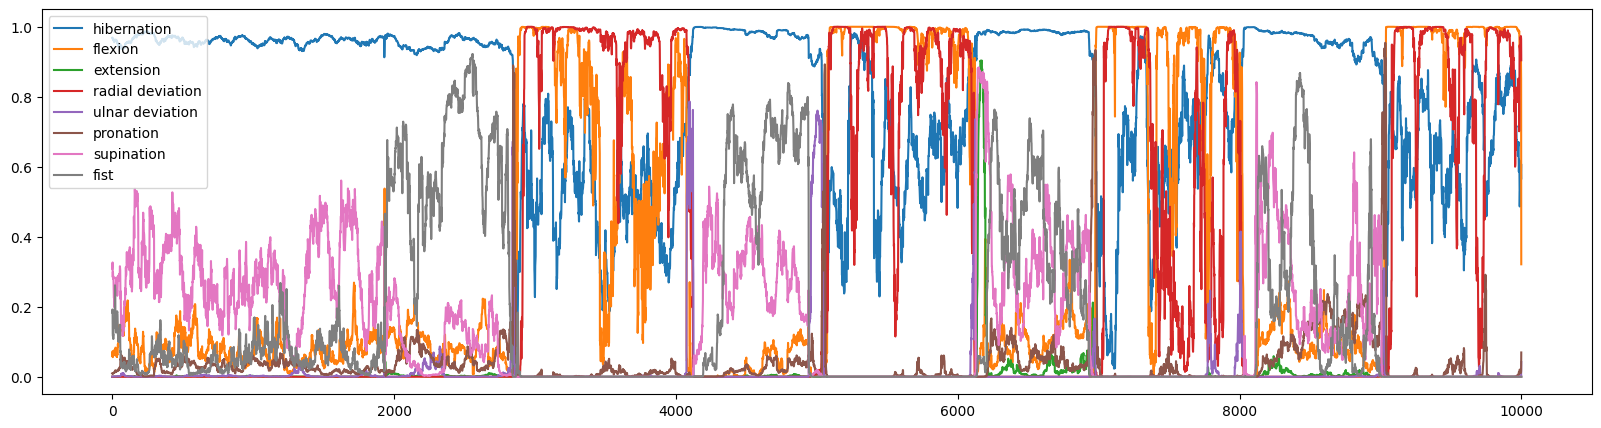

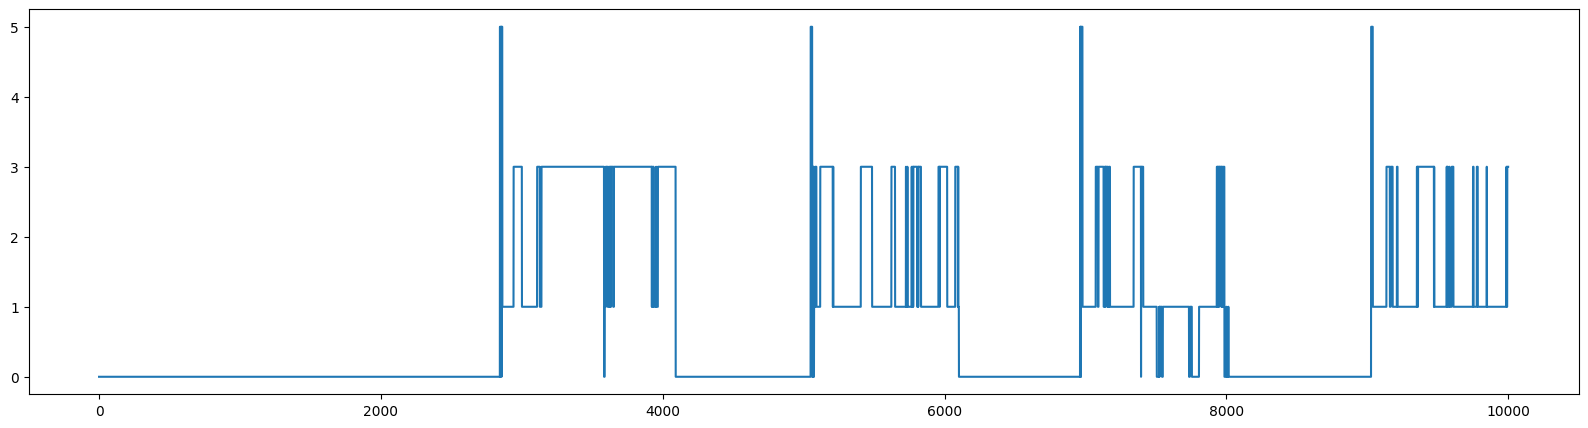

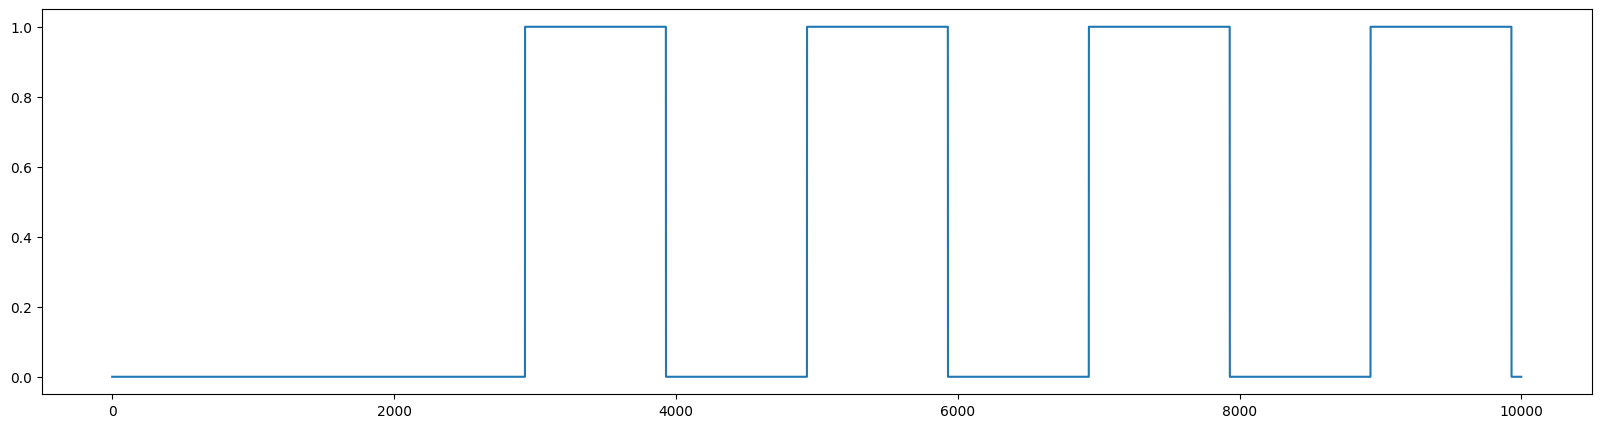

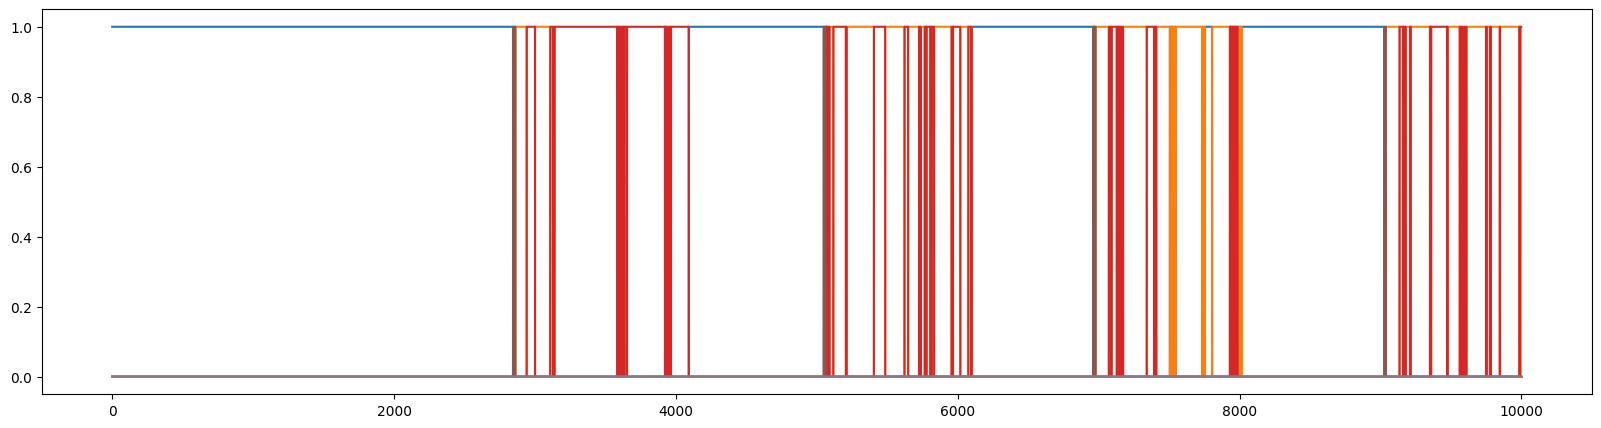

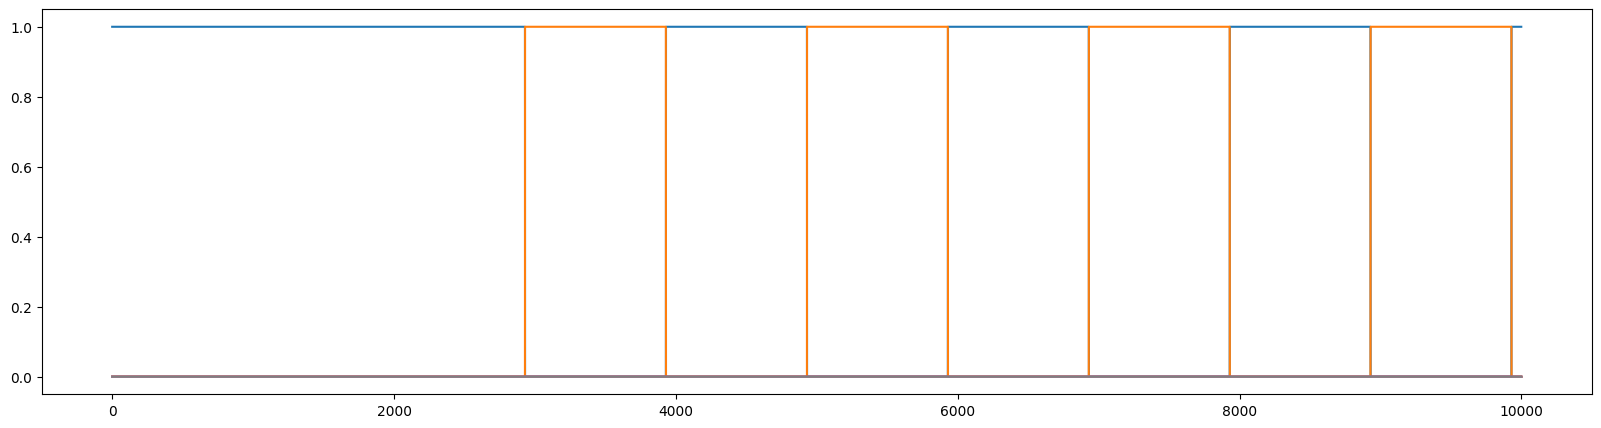

In [18]:
plt.figure()
plt.plot(predictions[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels[10000:20000])
plt.figure()
plt.plot(test_labels[10000:20000])
plt.figure()
plt.plot(predicted_labels_onehot[10000:20000])
plt.figure()
plt.plot(test_labels_onehot[10000:20000])

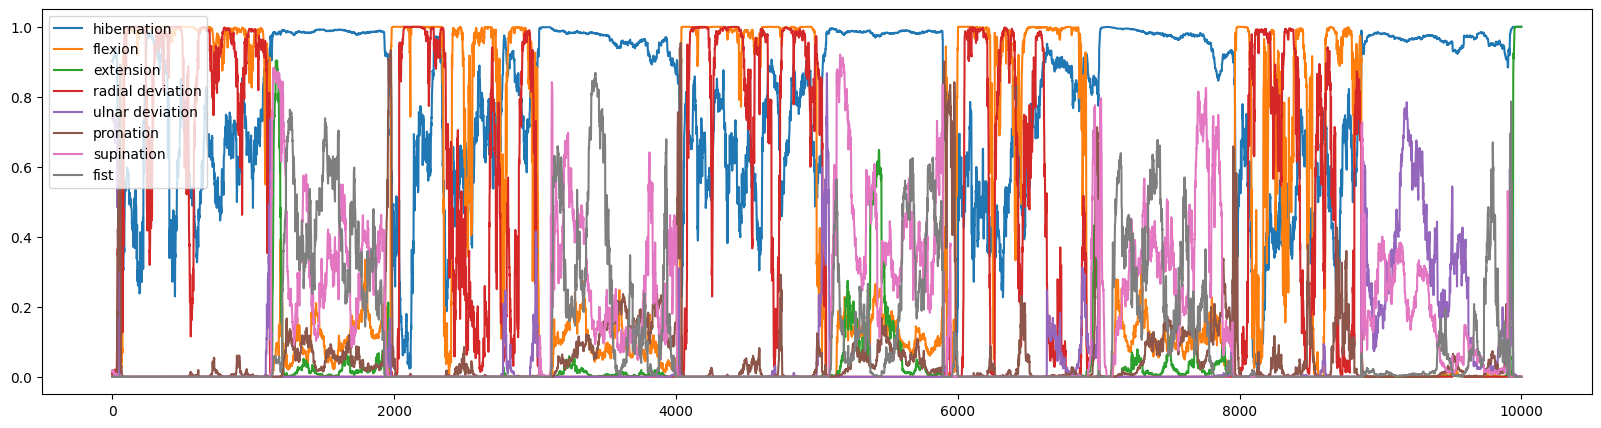

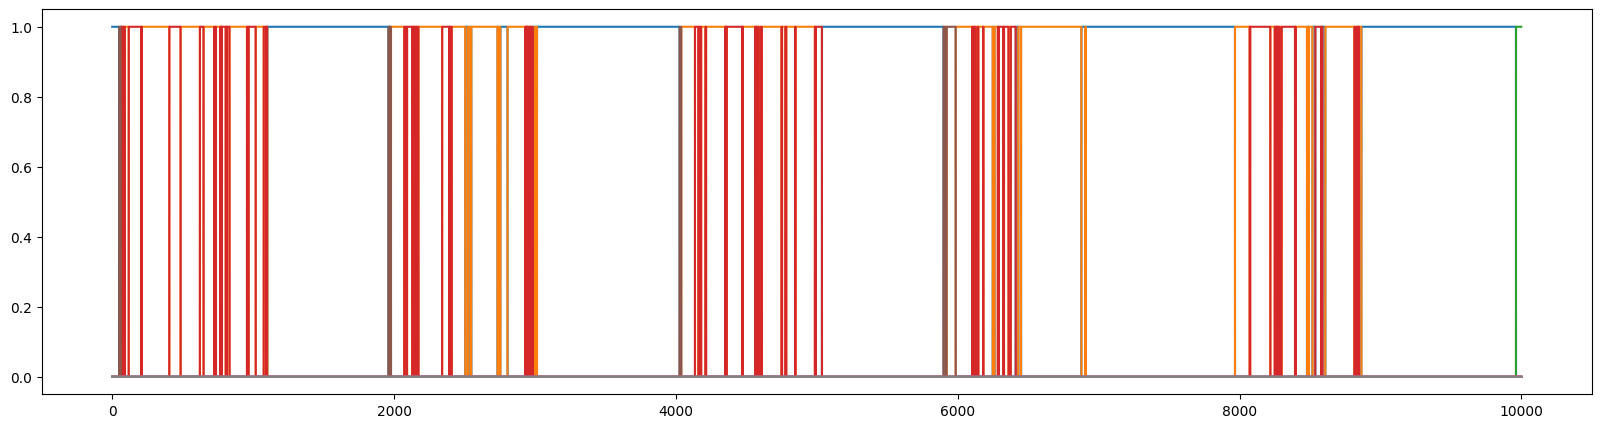

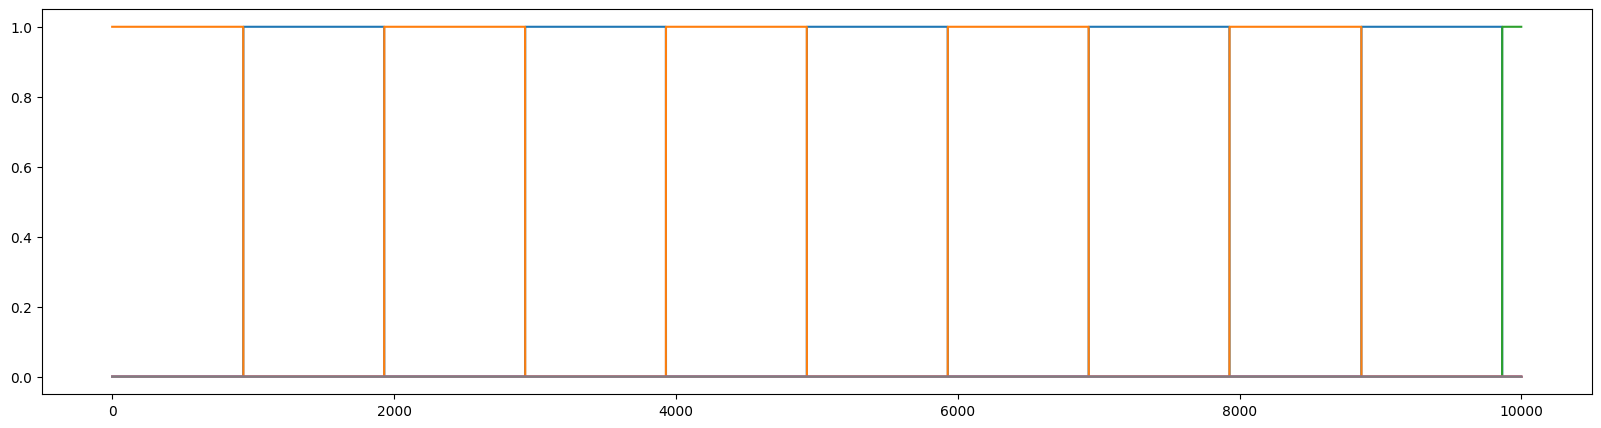

In [19]:
plt.figure()
plt.plot(predictions[15000:25000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels_onehot[15000:25000])
plt.figure()
plt.plot(test_labels_onehot[15000:25000])

In [20]:
training_analysis = model.predict(train)

15028/15028 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


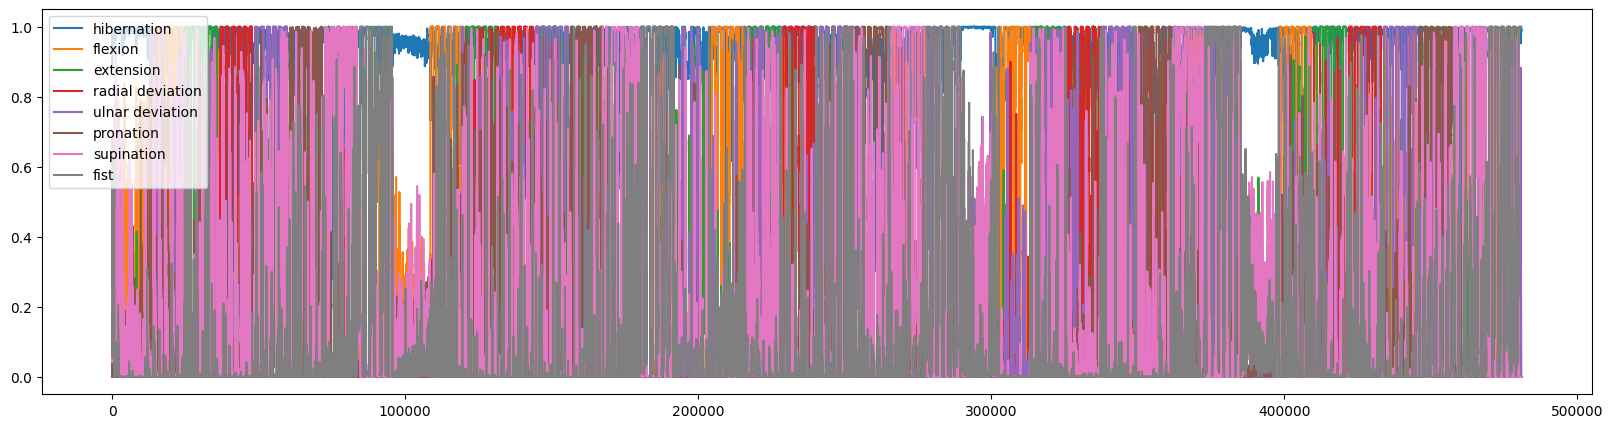

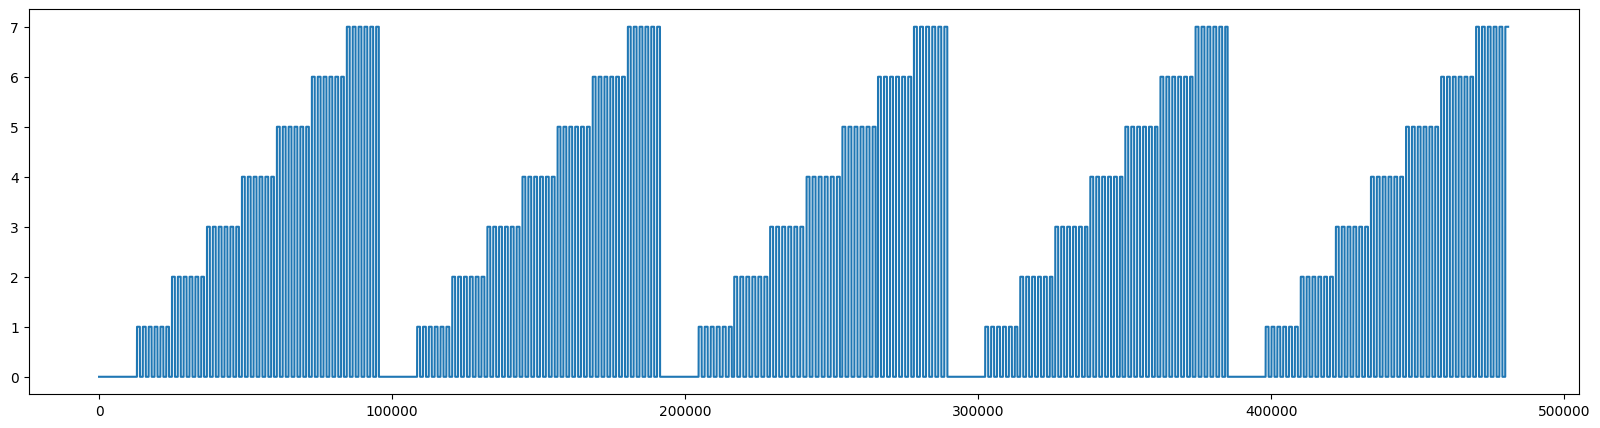

In [21]:
plt.figure()
plt.plot(training_analysis)
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels)

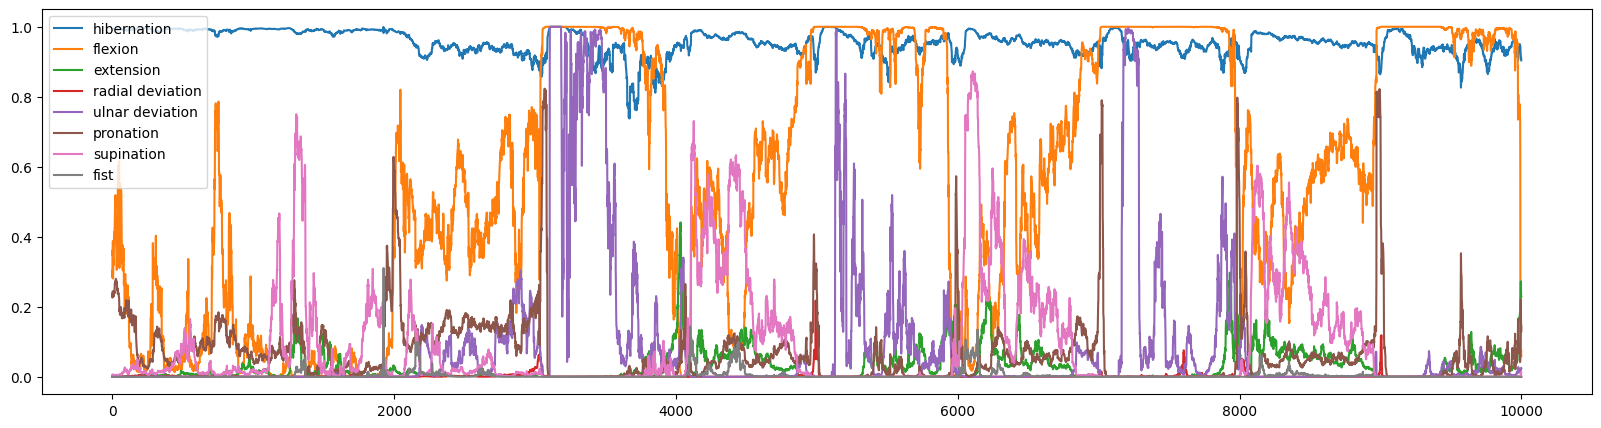

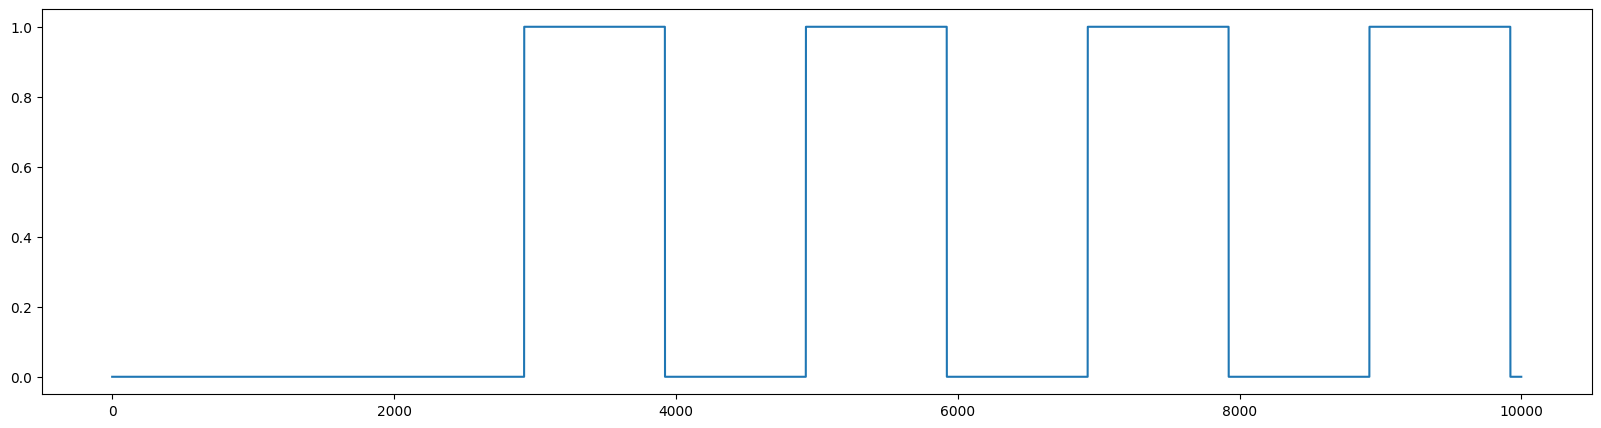

In [22]:
plt.figure()
plt.plot(training_analysis[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels[10000:20000])

## Grokking experiment

Same architecture, many epochs, no early stopping. Goal: observe whether validation accuracy improves late (delayed generalization).

In [ ]:
# Grokking attempt: train far past overfitting to look for delayed generalization
grok_model = keras.Sequential([
    keras.layers.Input(shape=(NUM_EMG_CHANNELS,)),
    keras.layers.Dense(LAYER_SIZES[0], activation="relu"),
    keras.layers.Dense(LAYER_SIZES[1], activation="relu"),
    keras.layers.Dense(LAYER_SIZES[2], activation="relu"),
    keras.layers.Dense(NUM_GESTURES, activation="sigmoid")
])
grok_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
grok_history = grok_model.fit(
    train, train_labels,
    validation_data=(valid, valid_labels),
    epochs=GROKKING_EPOCHS
)

Loss and accuracy over all grokking epochs; look for a late rise in validation accuracy.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(grok_history.history["loss"], label="train loss")
ax1.plot(grok_history.history["val_loss"], label="val loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend()
ax2.plot(grok_history.history["accuracy"], label="train accuracy")
ax2.plot(grok_history.history["val_accuracy"], label="val accuracy")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()

In [ ]:
grok_model.evaluate(test, test_labels)

Test-set confusion matrix for the grokking model (same interpretation: rows = ACTUAL, columns = PREDICTED, normalize=\"pred\" = precision per column).

In [ ]:
grok_preds = np.argmax(grok_model.predict(test), axis=1)
grok_conf = confusion_matrix(test_labels, grok_preds, normalize="pred")
plt.imshow(grok_conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(GESTURE_LABELS)), GESTURE_LABELS)
plt.xticks(np.arange(len(GESTURE_LABELS)), GESTURE_LABELS, rotation="vertical")
plt.colorbar()

Per-class precision, recall, F1 and support; macro and weighted averages at the bottom.

In [ ]:
print(classification_report(test_labels, grok_preds, target_names=GESTURE_LABELS))